# Train, Test and uniques ImageId

Thanks [@jeesper](https://www.kaggle.com/jesperdramsch) for the [SIIM ACR Pneumothorax Segmentation Data](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)

In [1]:
import numpy as np  
import pandas as pd 
import os
import pydicom
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# import mask utilities
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')
from mask_functions import rle2mask 

def extract_dcm_pixel_array(file_path):
    return pydicom.dcmread(file_path).pixel_array

def extract_dcm_metadata(file_path):
    ds = pydicom.dcmread(file_path)
    d = {}
    for elem in ds.iterall():
        if elem.name != 'Pixel Data' and elem.name != "Pixel Spacing" :
            d[elem.name.lower().replace(" ","_").replace("'s","")] = elem.value
        elif elem.name == "Pixel Spacing" :
            d["pixel_spacing_x"] = elem.value[0]
            d["pixel_spacing_y"] = elem.value[1]
            
    return d

def create_metadataset (df):

    ImageIds = []
    data  = []
    all_feats = set()    

    for index, row in tqdm ( df[["ImageId", "path"] ].drop_duplicates().iterrows() ) :            
        path = row["path"] 
        ImageId =  row["ImageId"]       
        feature_dict = extract_dcm_metadata (path)
        data.append(feature_dict)
        ImageIds.append(ImageId)
        feats = set (feature_dict.keys())
        if len ( feats - all_feats ) > 0:
            all_feats = all_feats.union(feats)


    df_meta = pd.DataFrame(columns=["ImageId"])
    df_meta["ImageId"]=ImageIds

    for feat in sorted(all_feats):
        df_meta[feat]=[ d[feat] for d in data ]

    df_meta['patient_age'] =  df_meta['patient_age'].map (lambda x: int(x))   
    return df_meta

DATA_PATH = "../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/"
SAMPLE_SUBMISSION = "../input/siim-acr-pneumothorax-segmentation/sample_submission.csv"

df_train  = pd.DataFrame([(name.replace(".dcm",""),  os.path.join(root, name)) for root, dirs, files in os.walk(DATA_PATH + "/dicom-images-train" )
             for name in files if name.endswith((".dcm"))], columns = ['ImageId','path']) 

df_test = pd.DataFrame([(name.replace(".dcm",""), os.path.join(root, name)) for root, dirs, files in os.walk(DATA_PATH + "/dicom-images-test" )
             for name in files if name.endswith((".dcm"))], columns = ['ImageId','path']) 

df_sub = pd.read_csv(SAMPLE_SUBMISSION)


df_rle = pd.read_csv(DATA_PATH + "/train-rle.csv")  
df_rle = df_rle.rename ( columns =  { ' EncodedPixels': 'EncodedPixels' })
df_rle ["EncodedPixels"] = df_rle ["EncodedPixels"].map(lambda x: x[1:])


df_train = df_train.merge(df_rle, on="ImageId", how="left")

not_pneumothorax_ImageId = set(df_train.query( "EncodedPixels == '-1' or EncodedPixels.isnull()",  engine='python') ["ImageId"])
df_train["pneumothorax"] = df_train["ImageId"].map(lambda x: 0 if x  in not_pneumothorax_ImageId else 1)


df_train["rle_count"] = df_train["ImageId"].map(df_rle.groupby(["ImageId"]).size())
df_train["rle_count"] = df_train["rle_count"].fillna(-1)  

## adding dicom metadata

df_meta = create_metadataset ( df_train )
meta_feats = [c for c in df_meta.columns if c != "ImageId" ]


df_train = df_train.merge(df_meta, on="ImageId", how='left') 
df_test = df_test.merge(create_metadataset ( df_test ), on="ImageId", how='left')


df_train.to_csv("train.csv",index=False)
df_test.to_csv("test.csv",index=False)

df_sub["entries"] = df_sub["ImageId"].map( df_sub.groupby(['ImageId']).size() )



print ( "train-rle: {}, unique ImageId: {}".format(len(df_rle), len(df_rle["ImageId"].unique()))) 
print ( "train: {}, unique ImageId: {}".format(len(df_train), len(df_train["ImageId"].unique()))) 
print("train ImageId not in rle: {}".format( 
    len( df_train.query ( "EncodedPixels.isnull()",  engine='python') )))
print("train ImageId with multiple rle: {}".format( 
    len( df_train.query ( "rle_count > 1",  engine='python')["ImageId"].unique() )))

print ( "sample_submission: {}, unique ImageId: {}, ImegeId with multiple entries: {}".format(
    len(df_sub), 
    len(df_sub["ImageId"].unique()), 
    len ( df_sub.query ( "entries > 1")["ImageId"].unique() )
    )) 

print ( "test: {}, unique ImageId: {}".format(len(df_test), len(df_test["ImageId"].unique())))
print("test ImageId not in sample_submission: {}".format( 
    len( df_test [ ~ df_test["ImageId"].isin(df_sub["ImageId"])])))


train-rle: 11582, unique ImageId: 10675
train: 11619, unique ImageId: 10712
train ImageId not in rle: 37
train ImageId with multiple rle: 624
sample_submission: 1484, unique ImageId: 1372, ImegeId with multiple entries: 78
test: 1377, unique ImageId: 1377
test ImageId not in sample_submission: 5


## X-Ray visualization


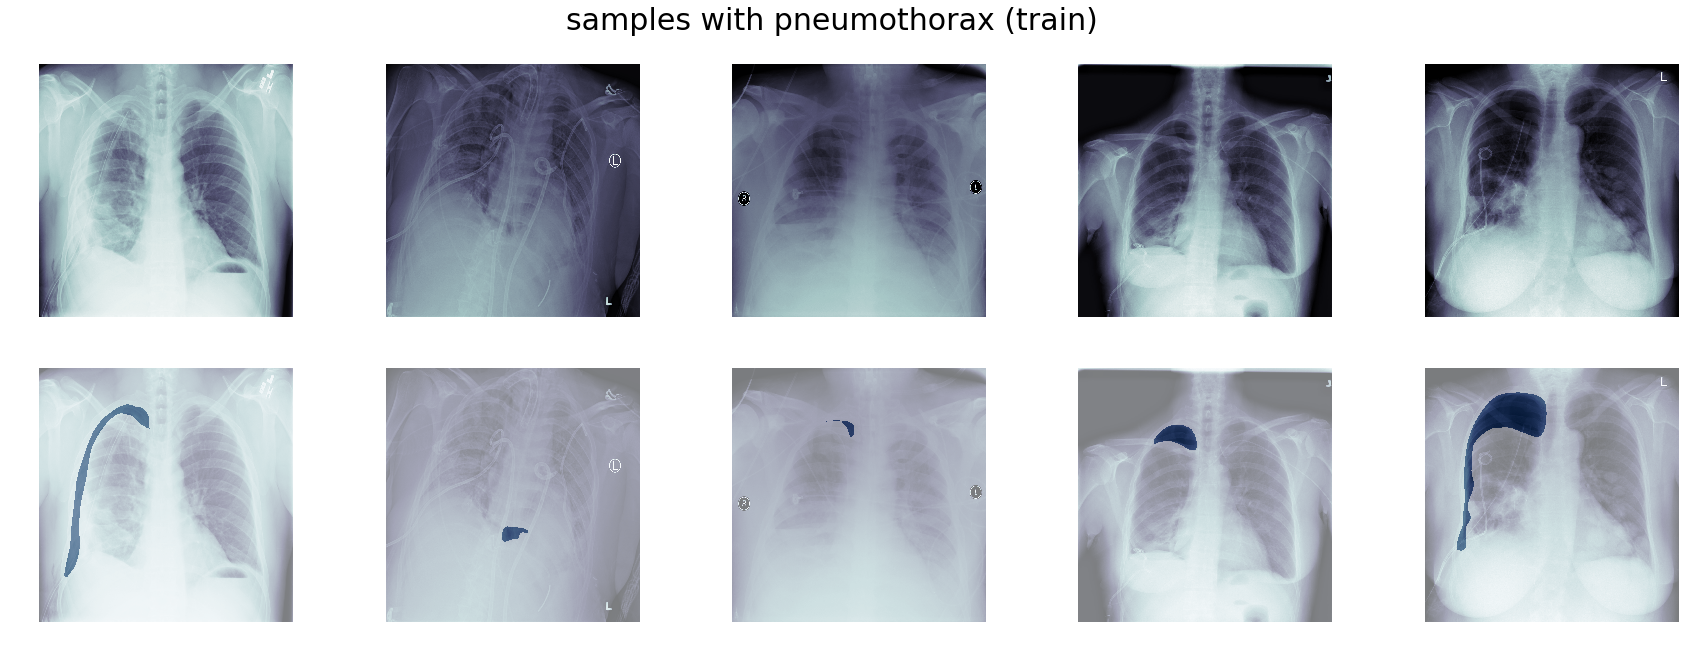

In [2]:
pneumothorax = df_train.query ( "pneumothorax == 1 and rle_count >= 1",  engine='python').sample(n=5).reset_index()

fig, axs = plt.subplots(2, 5, figsize=(30,10))
fig.suptitle("samples with pneumothorax (train)", fontsize=30)
for j, row in pneumothorax.iterrows():
    img = extract_dcm_pixel_array (row['path'])
    x = 0
    y = j % 5
    axs[x,y].imshow(img, cmap='bone')
    axs[x,y].axis('off')
    
    rle_mask = rle2mask(row["EncodedPixels"] , 1024, 1024).T
    x = 1
    axs[x,y].imshow(img, cmap='bone')
    axs[x,y].imshow(rle_mask, alpha=0.5, cmap="Blues")    
    axs[x,y].axis('off')
    
    
    
fig.subplots_adjust(top=0.9)


plt.show()

A visual explanation of "Chest x-ray - Pneumothorax or no pneumothorax" here [https://www.youtube.com/watch?v=0vZ9gVyWreo](https://www.youtube.com/watch?v=0vZ9gVyWreo)

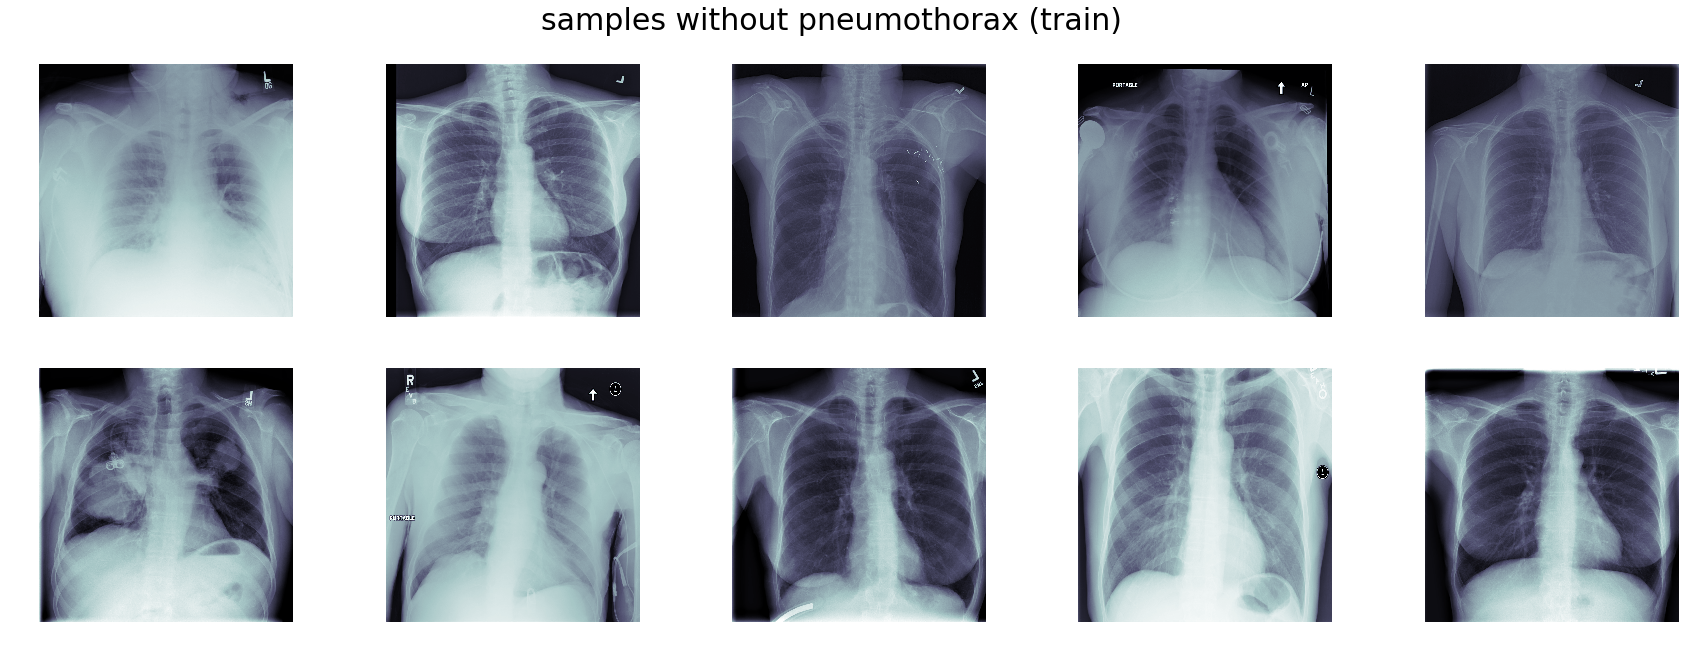

In [3]:
images = df_train.query ( "pneumothorax == 0",  engine='python')["path"].values
np.random.shuffle(images)


fig, axs = plt.subplots(2, 5, figsize=(30,10))
fig.suptitle("samples without pneumothorax (train)", fontsize=30)
for j, path in enumerate(images[:10]):
    img = extract_dcm_pixel_array (path)
    x = j // 5
    y = j % 5
    axs[x,y].imshow(img, cmap='bone')
    axs[x,y].axis('off')
fig.subplots_adjust(top=0.9)


plt.show()

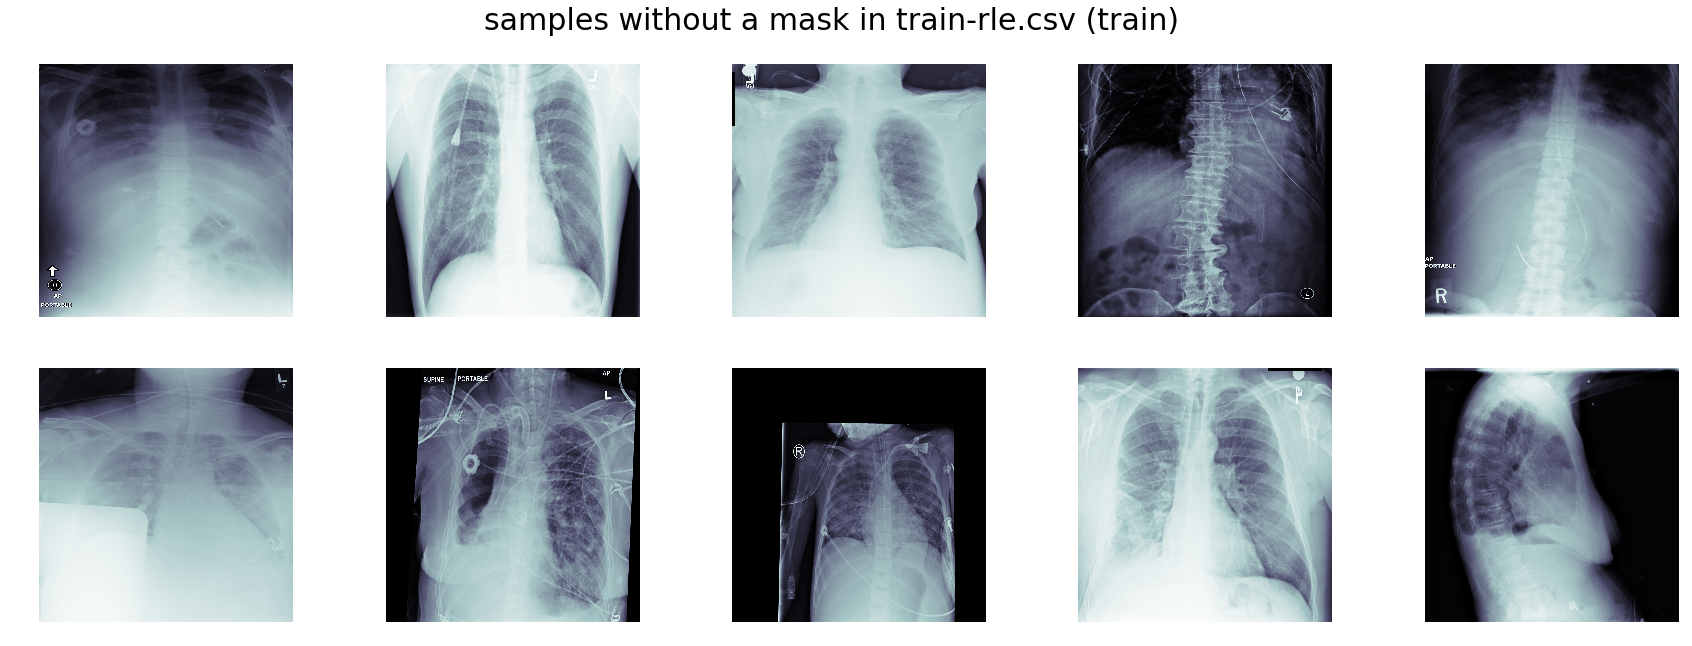

In [4]:
images = df_train.query ( "EncodedPixels.isnull()",  engine='python')["path"].values
np.random.shuffle(images)


fig, axs = plt.subplots(2, 5, figsize=(30,10))
fig.suptitle("samples without a mask in train-rle.csv (train)", fontsize=30)
for j, path in enumerate(images[:10]):
    img = extract_dcm_pixel_array (path)
    x = j // 5
    y = j % 5
    axs[x,y].imshow(img, cmap='bone')
    axs[x,y].axis('off')
fig.subplots_adjust(top=0.9)


plt.show()

in train set there are 37 images without a mask in train-rle.csv.  Some are misledeanig lateral position

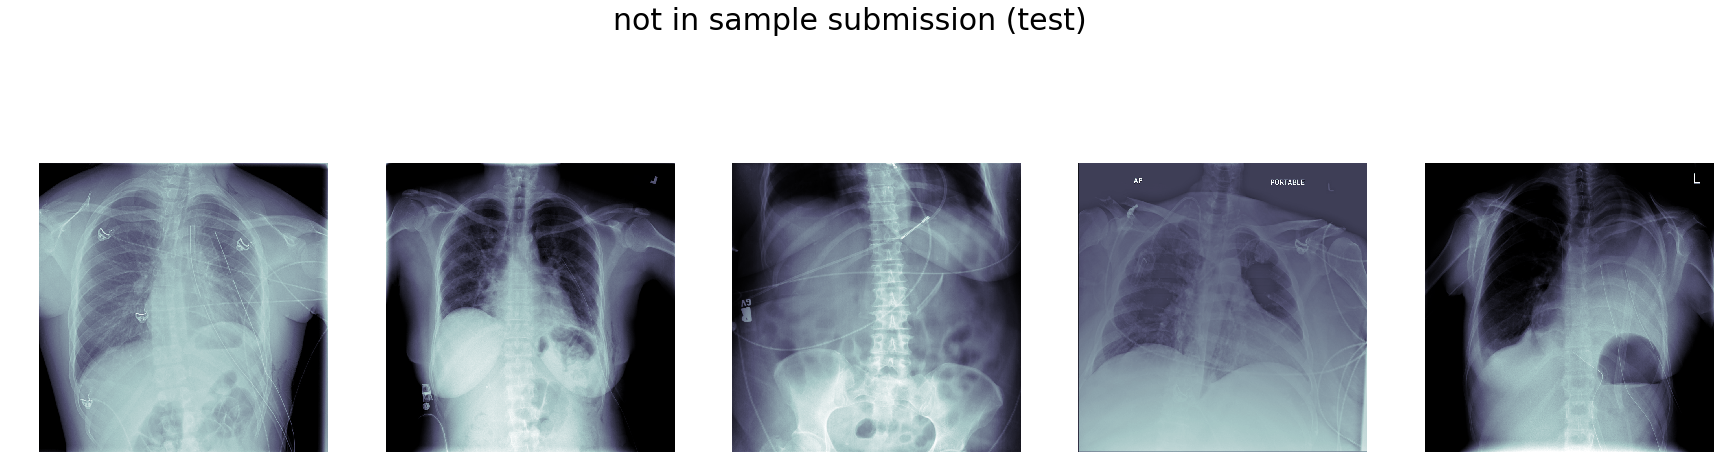

In [5]:
images = df_test [ ~ df_test["ImageId"].isin(df_sub["ImageId"])]["path"].values
np.random.shuffle(images)


fig, axs = plt.subplots(1, 5, figsize=(30,10))
fig.suptitle("not in sample submission (test)", fontsize=30)
for j, path in enumerate(images[:5]):
    img = extract_dcm_pixel_array (path)
    y = j % 5
    axs[y].imshow(img, cmap='bone')
    axs[y].axis('off')
fig.subplots_adjust(top=1.0)


plt.show()

in test set there are 5 images not in sample_submission.csv

# Images with multiple pneumothorax masks

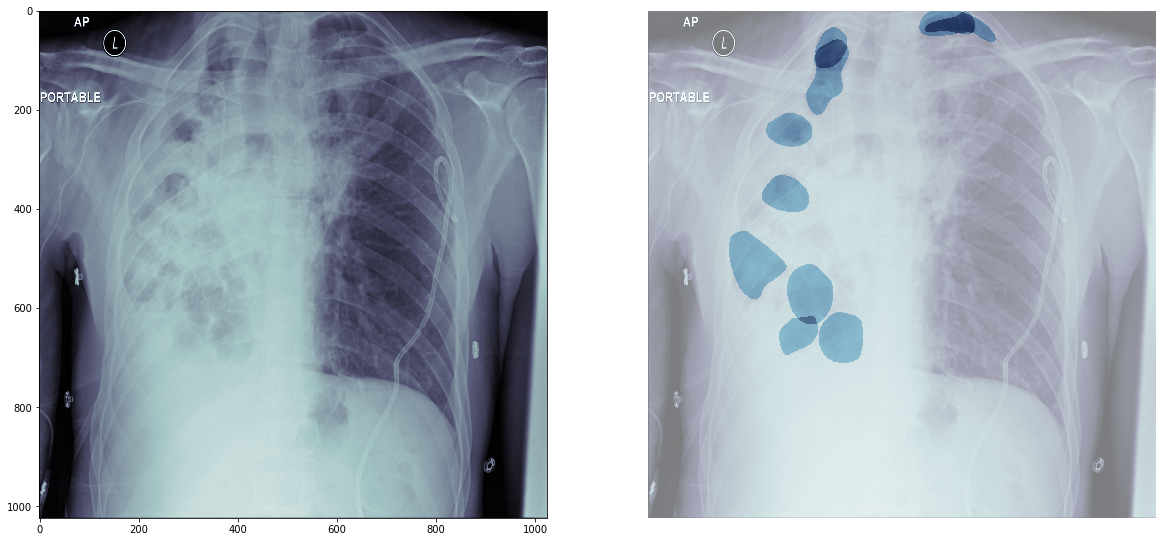

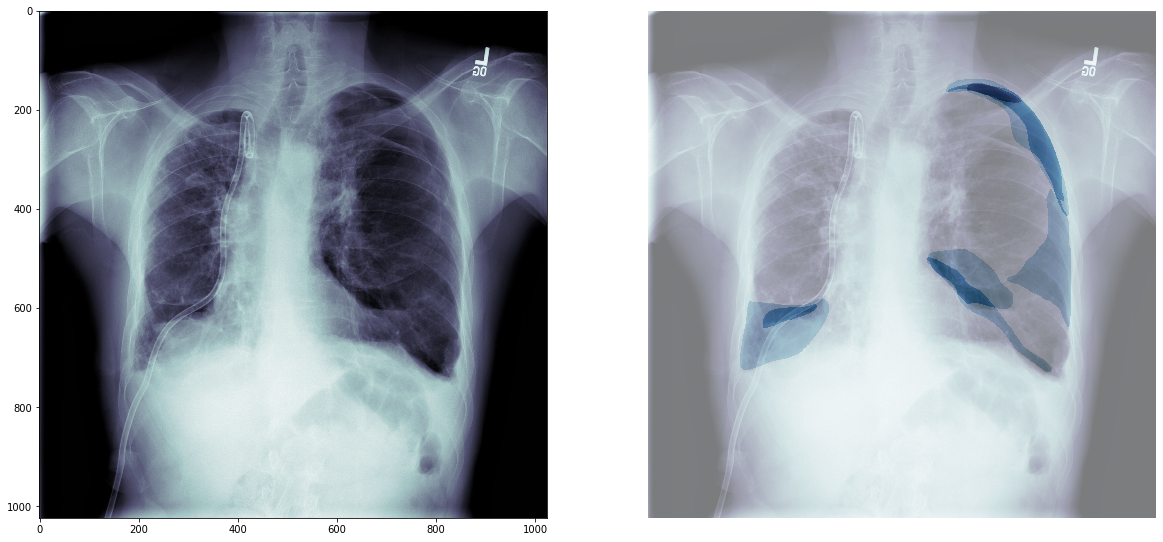

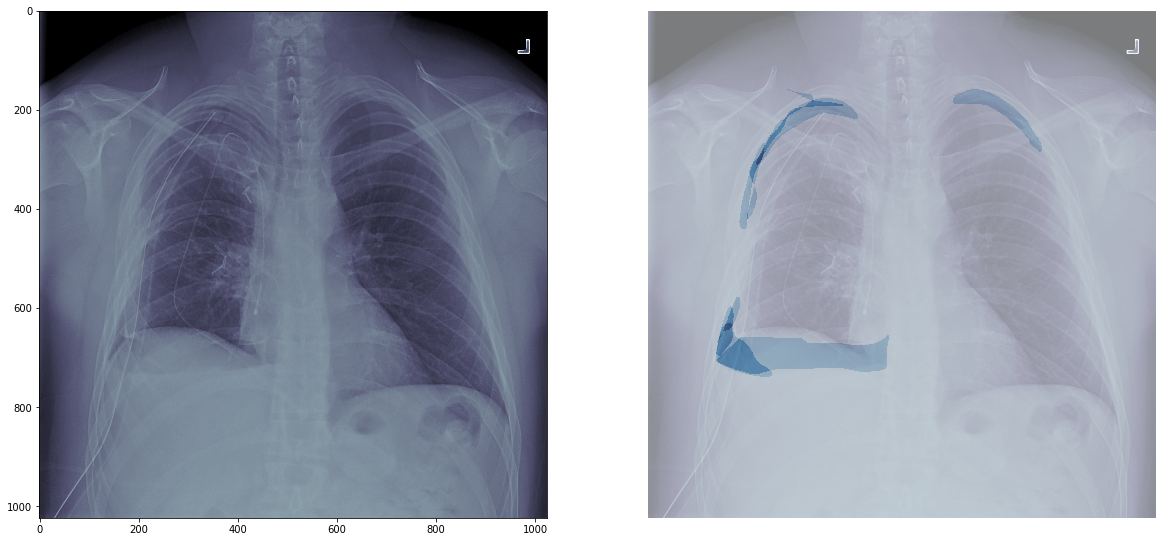

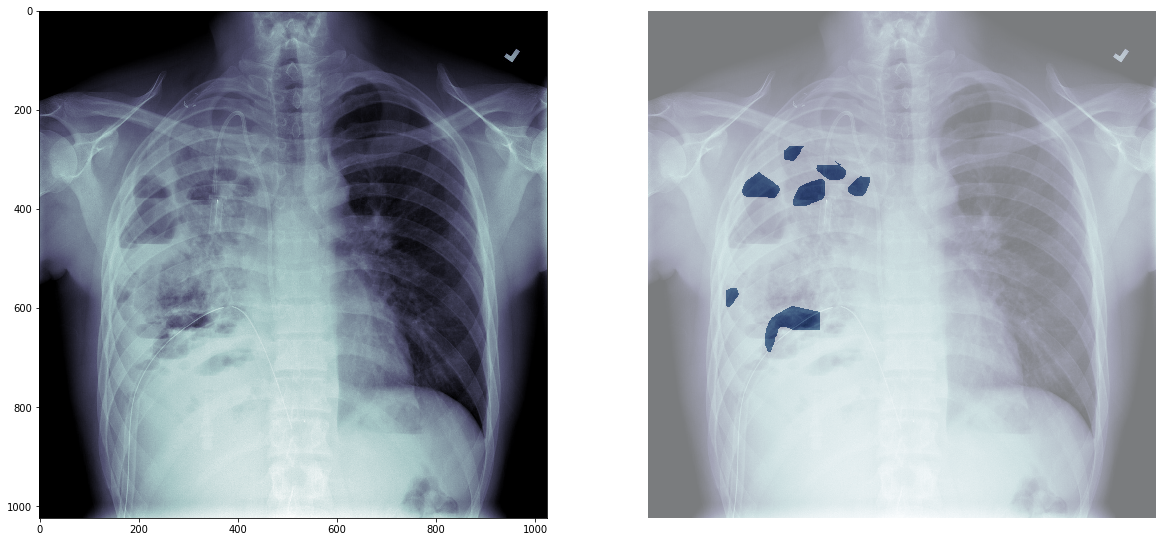

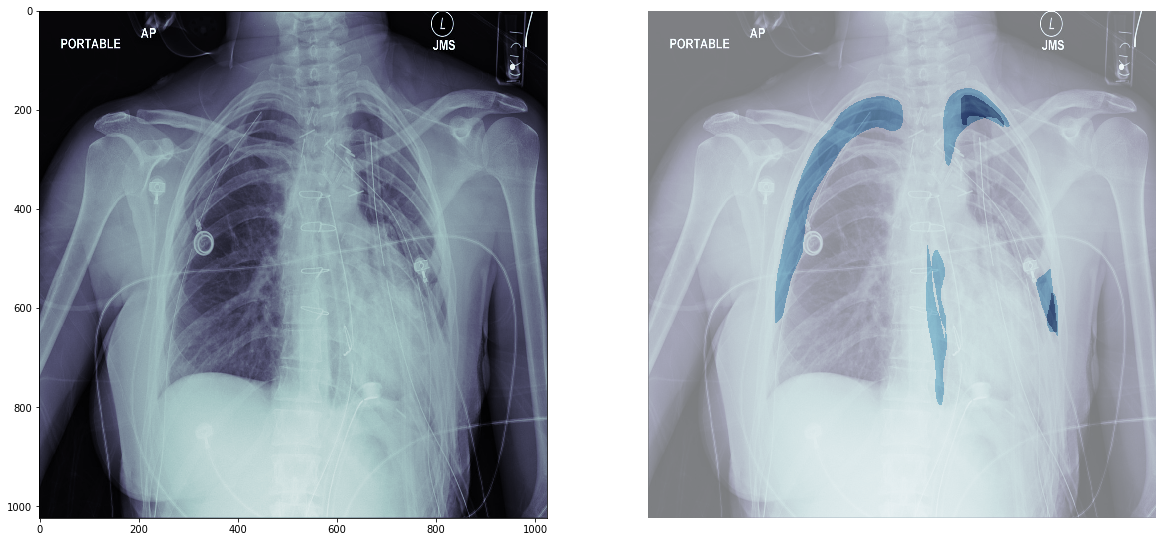

In [6]:
multiple_masks = df_train.query ( "rle_count > 1",  engine='python').sort_values(by="rle_count", ascending=False)
multiple_masks =  multiple_masks[["ImageId","path","rle_count"]].drop_duplicates() 
multiple_masks = multiple_masks [:5]

for i, row in multiple_masks.iterrows():
    path = row["path"]
    image_id = row["ImageId"]
    rle = df_train.query( "ImageId == '" + image_id + "'" )
    
    img = extract_dcm_pixel_array (path)
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20,10))
    
    #plt.set_title(image_id)
    ax[0].imshow(img, cmap='bone')
    ax[1].imshow(img, cmap='bone')

    rle_count = row["rle_count"]
    
    rle_mask = np.zeros ( (1024, 1024) )    
    for i, row in rle.iterrows():
        mask =  row["EncodedPixels"] 
        rle_mask += rle2mask(mask, 1024, 1024).T 

    ax[1].imshow(rle_mask, alpha=0.5, cmap="Blues")    

    plt.axis('off')
    plt.show()

in train set there are 624 images with multiple (**overlapping**) masks (in sample_submission there are 78 images with multiple entries)

# Metadata distributions

In [7]:
train_data = df_train.drop(["EncodedPixels"],axis=1).drop_duplicates()
train_data["dataset"] = "train"
test_data = df_test
test_data["dataset"] = "test"
all_data = train_data.append(test_data, sort=False)


print (  "metadata features in dicom : {}".format(  len(meta_feats) ))
print ("")
print ("metada features with single value:")
single_value_feats = [ c for c in  meta_feats if len(all_data[c].unique()) == 1]
for c in single_value_feats:
    print ( "{}: {}".format (c,all_data[c].unique()[0] ))
print ("")
print ("metada features with no duplicate value:")
no_duplicate_value_feats = [ c for c in  meta_feats if len(all_data[c].unique()) == all_data.shape[0]]
for c in no_duplicate_value_feats:
    print ( "{}: {}".format (c,all_data[c].unique()[:3] ))



metadata features in dicom : 35

metada features with single value:
accession_number: 
bits_allocated: 8
bits_stored: 8
body_part_examined: CHEST
columns: 1024
conversion_type: WSD
high_bit: 7
instance_number: 1
lossy_image_compression: 01
lossy_image_compression_method: ISO_10918_1
modality: CR
patient_birth_date: 
patient_orientation: 
photometric_interpretation: MONOCHROME2
pixel_representation: 0
rows: 1024
samples_per_pixel: 1
series_number: 1
sop_class_uid: 1.2.840.10008.5.1.4.1.1.7
specific_character_set: ISO_IR 100
study_date: 19010101
study_id: 
study_time: 000000.00

metada features with no duplicate value:
patient_id: ['649955f2-6210-461c-8ad7-bcec9494ef5e'
 '911ec56d-b45d-4aa3-b61f-6e77eed4a27e'
 '43d62c0c-1515-4aef-a6ea-46123bf365c4']
patient_name: ['649955f2-6210-461c-8ad7-bcec9494ef5e'
 '911ec56d-b45d-4aa3-b61f-6e77eed4a27e'
 '43d62c0c-1515-4aef-a6ea-46123bf365c4']
series_instance_uid: ['1.2.276.0.7230010.3.1.3.8323329.10687.1517875225.75978'
 '1.2.276.0.7230010.3.1.3.83

There are 37 features in dicom.  
27 features have a single value.  
5 features have distinct value per distinct row.  
7 have a non trivial distribution with pixel_spacing_x/pixel_spacing_y and view_position/series_description sharing the same information
  
### Metada features with no trivial distribution

In [8]:
meta_feats = [c for c in meta_feats if c not in single_value_feats and c not in no_duplicate_value_feats]
all_data[[c for c in meta_feats  ]].describe(include='all')



patient_age patient_sex      ...        series_description  view_position
count   12089.000000       12089      ...                     12089          12089
unique           NaN           2      ...                         2              2
top              NaN           M      ...                  view: PA             PA
freq             NaN        6650      ...                      7290           7290
mean       46.987178         NaN      ...                       NaN            NaN
std        17.091074         NaN      ...                       NaN            NaN
min         1.000000         NaN      ...                       NaN            NaN
25%        35.000000         NaN      ...                       NaN            NaN
50%        49.000000         NaN      ...                       NaN            NaN
75%        59.000000         NaN      ...                       NaN            NaN
max       413.000000         NaN      ...                       NaN            NaN

[11 rows x 7 columns]

# Metadata distributions

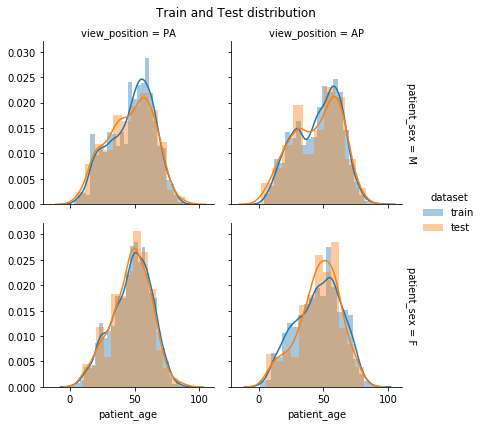

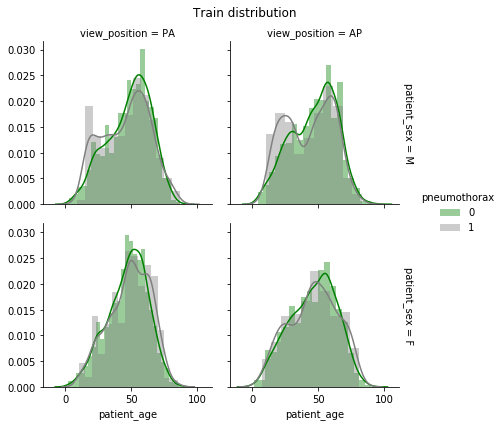

In [9]:
g = sns.FacetGrid(all_data.query ( "patient_age < 100"  ), 
                  hue='dataset', row="patient_sex", col='view_position',  margin_titles=True)
g.map(sns.distplot, "patient_age").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Train and Test distribution")
plt.show()

g = sns.FacetGrid(train_data.query ( "patient_age < 100"  ), palette= {0:"green", 1:"gray"},
                  hue='pneumothorax', row="patient_sex", col='view_position',  margin_titles=True)
g.map(sns.distplot, "patient_age").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Train distribution")
plt.show()

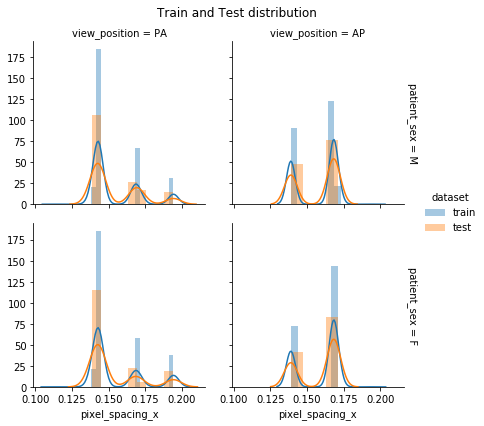

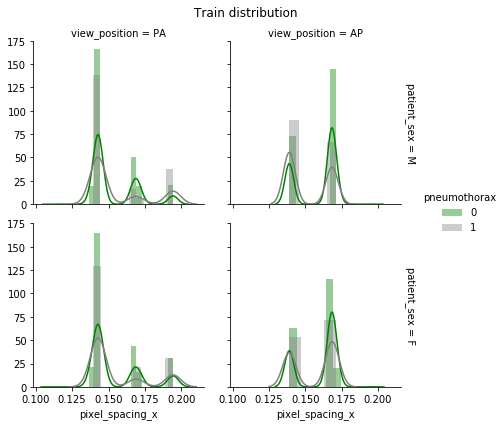

In [10]:
g = sns.FacetGrid(all_data, 
                  hue='dataset', row="patient_sex", col='view_position',  margin_titles=True)
g.map(sns.distplot, "pixel_spacing_x").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Train and Test distribution")
plt.show()

g = sns.FacetGrid(train_data, palette= {0:"green", 1:"gray"},
                  hue='pneumothorax', row="patient_sex", col='view_position',  margin_titles=True)
g.map(sns.distplot, "pixel_spacing_x").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Train distribution")
plt.show()

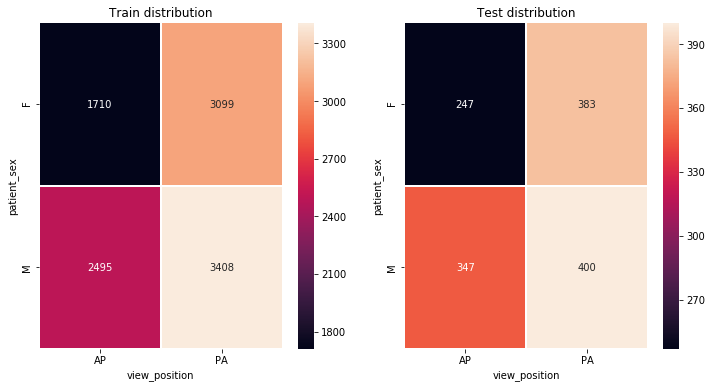

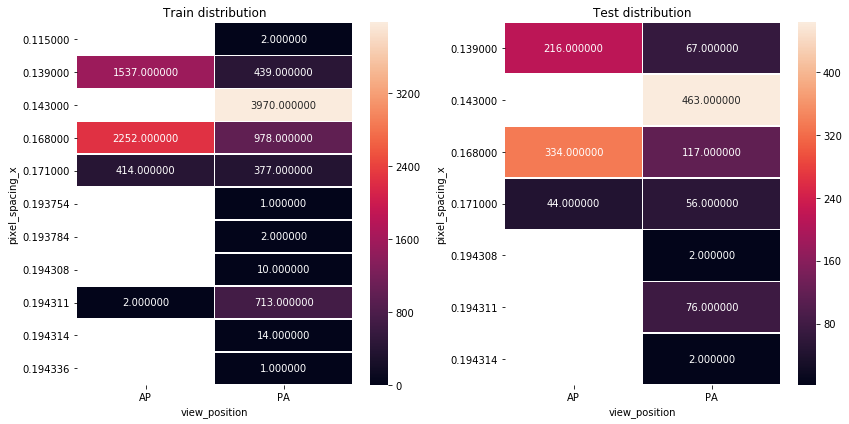

In [11]:
pvt_train = train_data.groupby(["view_position", "patient_sex"]).agg({"ImageId":'count'}).reset_index().pivot(index="patient_sex",columns="view_position", values="ImageId")
pvt_test = test_data.groupby(["view_position", "patient_sex"]).agg({"ImageId":'count'}).reset_index().pivot(index="patient_sex",columns="view_position", values="ImageId")

f, axes = plt.subplots(1, 2, figsize=(12, 6))

g = sns.heatmap(pvt_train, annot=True, fmt="d", linewidths=.5, ax=axes[0])
axes[0].title.set_text("Train distribution")
sns.heatmap(pvt_test, annot=True, fmt="d", linewidths=.5,   ax=axes[1])
axes[1].title.set_text("Test distribution")

plt.show()


df =train_data.groupby(["view_position", "pixel_spacing_x"]).agg({"ImageId":'count'}).reset_index()
df["pixel_spacing_x"] = df["pixel_spacing_x"].map(lambda x: "{0:.6f}".format(x)) 
pvt_train = df.pivot(index="pixel_spacing_x",columns="view_position", values="ImageId")

df = test_data.groupby(["view_position", "pixel_spacing_x"]).agg({"ImageId":'count'}).reset_index()
df["pixel_spacing_x"] = df["pixel_spacing_x"].map(lambda x: "{0:.6f}".format(x)) 

pvt_test = df.pivot(index="pixel_spacing_x",columns="view_position", values="ImageId")

f, axes = plt.subplots(1, 2, figsize=(12, 6))

g = sns.heatmap(pvt_train, annot=True, fmt="f", linewidths=.5, ax=axes[0])
axes[0].title.set_text("Train distribution")
sns.heatmap(pvt_test, annot=True, fmt="f", linewidths=.5,  ax=axes[1])
axes[1].title.set_text("Test distribution")
plt.tight_layout() 
plt.show()

# The bimodal mean_pixel_value distribution
see [@Giulia Savorgnan's](https://www.kaggle.com/giuliasavorgnan) [discussion](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/97525)

In [12]:
del df_train, df_test 

test_data["pixel_array"] = test_data["path"].map(lambda x : extract_dcm_pixel_array(x) )
test_data["mean_pixel_value"]= test_data["pixel_array"].map(lambda x : (x.mean()))

test_data = test_data.drop ( ["pixel_array"], axis=1 ) 

train_data["pixel_array"] = train_data["path"].map(lambda x : extract_dcm_pixel_array(x) )
train_data["mean_pixel_value"]= train_data["pixel_array"].map(lambda x : (x.mean()))
train_data = train_data.drop ( ["pixel_array"], axis=1 ) 

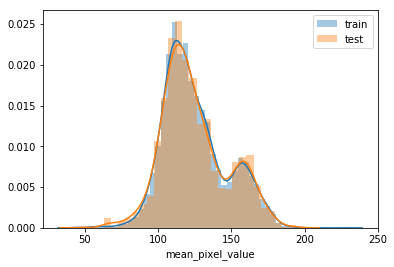

In [13]:
sns.distplot(train_data["mean_pixel_value"], label="train")
sns.distplot(test_data["mean_pixel_value"], label="test")
plt.legend()
plt.show()

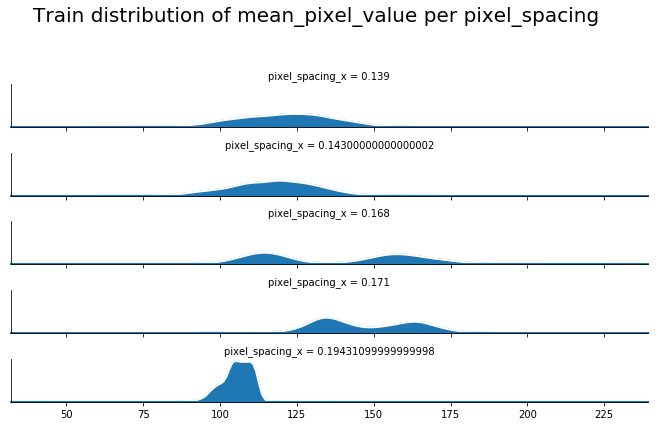

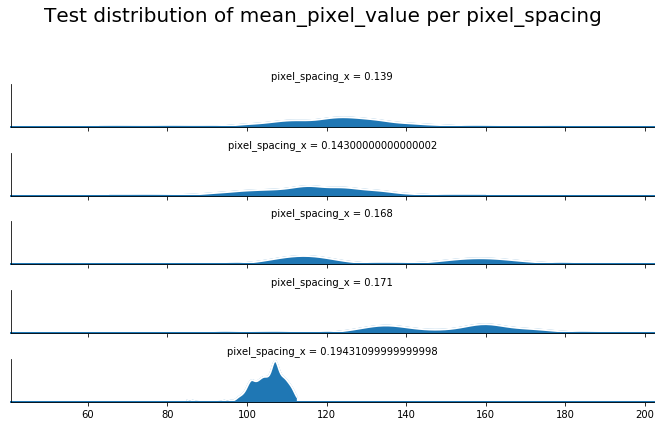

In [14]:
g = sns.FacetGrid(
    train_data.query( "(pixel_spacing_x > 0.116 and  pixel_spacing_x < 0.172 or ( pixel_spacing_x > 0.194309 and  pixel_spacing_x < 0.194313))" ), 
    row="pixel_spacing_x",  aspect=8, height=1.2)

g.map(sns.kdeplot, "mean_pixel_value", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "mean_pixel_value", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

g.set(yticks=[])
g.fig.suptitle("Train distribution of mean_pixel_value per pixel_spacing",fontsize=20)
plt.subplots_adjust(top=0.8)

plt.show()


g = sns.FacetGrid(
    test_data.query( "pixel_spacing_x < 0.172 or ( pixel_spacing_x > 0.194309 and  pixel_spacing_x < 0.194313 )" ), 
    row="pixel_spacing_x",  aspect=8, height=1.2)

g.map(sns.kdeplot, "mean_pixel_value", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "mean_pixel_value", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.set(yticks=[])
g.fig.suptitle("Test distribution of mean_pixel_value per pixel_spacing", fontsize=20)
plt.subplots_adjust(top=0.8)

plt.show()



so, it seems that distribution of mean_pixel_value is correlated with dicom pixel_spacing attribute.
For pixel_spacing's reference see http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_10.7.html#sect_10.7.1.3
  
let's see how view position PA/AP impacts the distribution of mean_pixel_value


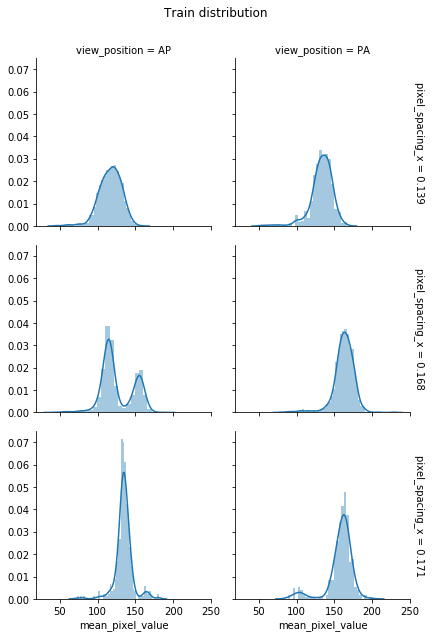

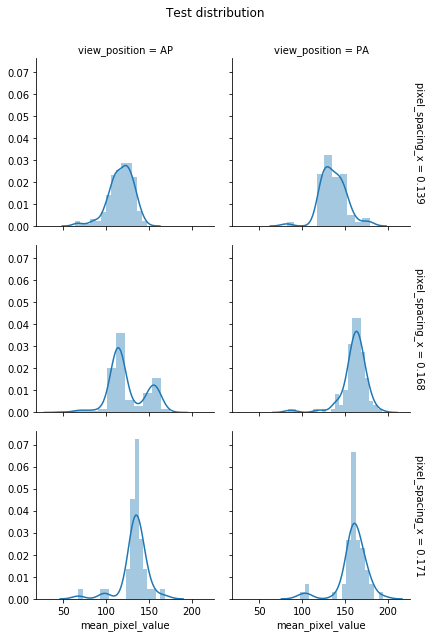

In [15]:
g = sns.FacetGrid(
    train_data.query('(pixel_spacing_x > 0.115 and pixel_spacing_x < 0.142) or (pixel_spacing_x > 0.167 and pixel_spacing_x < 0.193) ' ),
    row="pixel_spacing_x", col='view_position', col_order=['AP','PA'],  margin_titles=True)
g.map(sns.distplot, "mean_pixel_value").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Train distribution")
plt.show()

g = sns.FacetGrid(
    test_data.query('(pixel_spacing_x > 0.115 and pixel_spacing_x < 0.142) or (pixel_spacing_x > 0.167 and pixel_spacing_x < 0.193) ' ),
    row="pixel_spacing_x", col='view_position', col_order=['AP','PA'], margin_titles=True)
g.map(sns.distplot, "mean_pixel_value").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Test distribution")
plt.show()

with fixed pixel spacing, the average pixel value is higher for PA than AP.  
The bimodal distribution is the sum of these distributions.



### How do PA and AP chest X-ray differ?
PA view is the most commonly taken view of chest.   
Patient is erect facing the upright image receptor.   

AP view is taken only in certain conditions where patient is completely bed ridden and is not able to stand or sit in an erect posture   
AP radiographs are taken with the tube in front of the patient with the detector behind the patient. These are usually done with portable equipment. The tube is typically closer to the patient and so penumbra is greater. 

[https://www.youtube.com/watch?v=8ZAN6vEuYjY](https://www.youtube.com/watch?v=8ZAN6vEuYjY)

[https://www.quora.com/How-do-PA-and-AP-chest-X-ray-differ](https://www.quora.com/How-do-PA-and-AP-chest-X-ray-differ)
[https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)

how about bimodal view_position = AP and pixel_spacing = 0.168 ?